# Frost Weather Data
By: Magnus Kvåle Helliesen

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import requests
import toml
from datetime import date
from ipywidgets import interact, SelectMultiple
from mpl_toolkits.basemap import Basemap
from statsmodels.tsa.arima.model import ARIMA
from math import pi

In [3]:
# Credentials from https://frost.met.no/auth/requestCredentials.html
with open('credentials.toml', 'r') as file:
    credentials = toml.load(file)

## Finding list of stations and choosing using widget

In [4]:
endpoint = 'https://frost.met.no/sources/v0.jsonld'

parameters = {
    'types': 'SensorSystem',
    'validtime': '2000-01-01/2010-01-01'
}

r = requests.get(endpoint, parameters, auth=(credentials.get('credentials').get('client_id'),''))

json = r.json()

In [29]:
# Get all stations owned by MET.NO that are still up and running
df_stations = pd.json_normalize(json.get('data')).explode('stationHolders').query('stationHolders == "MET.NO"')
df_stations = pl.from_pandas(df_stations)
df_stations = df_stations.filter(df_stations['validTo'].is_null())
df_stations = df_stations.sort('shortName')

In [37]:
# Make a dict with station id and name pairs
names_id = {x: y for x, y in zip(df_stations['shortName'], df_stations['id'])}
id_names = {val: key for key, val in names_id.items()}

# Choose stations from menu widget
@interact(id=SelectMultiple(options=names_id, rows=20))
def select_station(id):
    global stations
    stations = id
    display(df_stations.filter(df_stations['id'].is_in(id)).transpose)

interactive(children=(SelectMultiple(description='id', options={'Alta LH': 'SN93140', 'Andøya LH': 'SN87110', …

In [38]:
# Override widgets above, comment out if widget input is wanted
stations = [
    'SN50540',
    'SN25830',
    'SN41770',
    'SN82290',
    'SN99910',
    'SN68860',
    'SN90450',
    'SN18700'
]

## Showing locations on map

In [44]:
# Get marker data for map from dataframe
markers = []
for station in stations:
    markers += df_stations.filter(df_stations['id'] == station)[['shortName', 'geometry.coordinates']].rows()

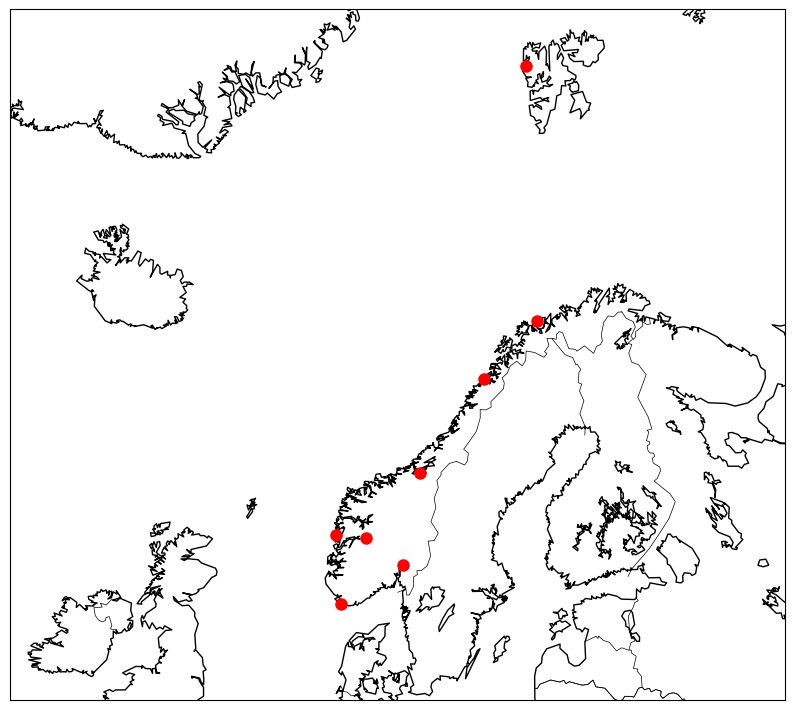

In [46]:
# Create a figure
plt.figure(figsize=(10, 10))

# Create a Basemap with extended boundaries to include Svalbard and Jan Mayen
map = Basemap(
    projection='aeqd',
    lat_0=60, lon_0=25,
    resolution='l',
    area_thresh=1000.0,
    llcrnrlon=-10,
    llcrnrlat=50,
    urcrnrlon=64,
    urcrnrlat=79
)

# Draw coastline and political boundaries
map.drawcoastlines()
map.drawcountries()

# Add points (latitude and longitude) to the map
points = [x[1][::-1] for x in markers]

lats, lons = zip(*points)
x, y = map(lons, lats)

# Plot points on the map
map.plot(x, y, 'ro', markersize=8)

plt.show()

## Retrieving data using Frost API

In [47]:
endpoint = 'https://frost.met.no/observations/v0.jsonld'

parameters = {
    'sources': ','.join(stations),
    'elements': 'mean(air_temperature P1D)',
    'referencetime': f'1990-01-01/{date.today()}'
}

r = requests.get(endpoint, parameters, auth=(credentials.get('credentials').get('client_id'),''))

if r.status_code == 200:
    json = r.json()
else:
    raise ValueError('No data retrieved')

In [116]:
# Store JSON to DataFrame
df = pd.json_normalize(json.get('data'), 'observations', ['sourceId', 'referenceTime'])
df = pl.from_pandas(df)
df = df[['sourceId', 'referenceTime', 'value']]
df = df.with_columns(df['sourceId'].str.replace_all(':0','').alias('sourceId'))
df.describe()

describe,sourceId,referenceTime,value
str,str,str,f64
"""count""","""186325""","""186325""",186325.0
"""null_count""","""0""","""0""",0.0
"""mean""",null,null,4.373391
"""std""",null,null,8.079071
"""min""","""SN18700""","""1990-01-01T00:…",-34.6
"""25%""",null,null,-0.5
"""50%""",null,null,4.7
"""75%""",null,null,10.3
"""max""","""SN99910""","""2023-11-18T00:…",28.0


In [117]:
# Some data wrangling/re-shaping
df = df.group_by(['sourceId', 'referenceTime']).mean()
df = df.with_columns((df['referenceTime'].cast(pl.Datetime)).alias('referenceTime'))
df

sourceId,referenceTime,value
str,datetime[μs],f64
"""SN18700""",1990-01-04 00:00:00,-4.0
"""SN18700""",1990-01-09 00:00:00,2.2
"""SN18700""",1990-01-15 00:00:00,3.4
"""SN18700""",1990-01-20 00:00:00,1.6
"""SN18700""",1990-01-24 00:00:00,2.0
"""SN18700""",1990-01-25 00:00:00,-1.05
"""SN18700""",1990-02-02 00:00:00,5.35
"""SN18700""",1990-02-13 00:00:00,2.1
"""SN18700""",1990-02-16 00:00:00,-2.35


In [118]:
df = df.pivot(index='referenceTime', columns='sourceId', values='value')
df = df.sort('referenceTime')
df.describe()

describe,referenceTime,SN18700,SN25830,SN41770,SN50540,SN68860,SN82290,SN90450,SN99910
str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""12375""",12375.0,12375.0,12375.0,12375.0,12375.0,12375.0,12375.0,12375.0
"""null_count""","""0""",0.0,1626.0,0.0,0.0,2449.0,0.0,0.0,10.0
"""mean""",null,7.032707,-1.080395,8.615111,8.435576,6.018925,5.530416,3.403572,-4.020704
"""std""",null,7.966359,7.667213,5.577379,5.705324,6.997673,6.120465,6.42462,7.735201
"""min""","""1990-01-01 00:…",-17.85,-34.4,-10.9,-11.7,-19.45,-13.45,-15.95,-33.3
"""25%""",null,1.05,-5.8,4.55,4.25,1.25,1.15,-1.45,-9.5
"""50%""",null,6.7,-0.8,8.35,8.15,5.75,5.25,2.85,-3.15
"""75%""",null,13.95,4.75,13.3,12.9,11.4,10.3,8.6,2.4
"""max""","""2023-11-18 00:…",26.35,17.0,23.3,26.1,26.05,24.5,24.15,13.3


In [119]:
# Looking at a slice of the final data
df.tail()

referenceTime,SN18700,SN25830,SN41770,SN50540,SN68860,SN82290,SN90450,SN99910
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2023-11-14 00:00:00,-0.9,-7.35,2.35,3.3,-3.35,-2.75,-5.05,-13.35
2023-11-15 00:00:00,-2.25,-8.2,1.8,1.55,-5.25,-4.4,-2.0,-15.35
2023-11-16 00:00:00,-3.55,-9.2,1.05,2.8,-7.25,-3.4,-1.0,-13.55
2023-11-17 00:00:00,-3.25,-14.15,0.4,0.5,-5.75,0.3,-0.5,-11.75
2023-11-18 00:00:00,-6.5,-15.5,1.9,0.95,-5.7,1.95,-1.45,-13.9


## Graphing the data

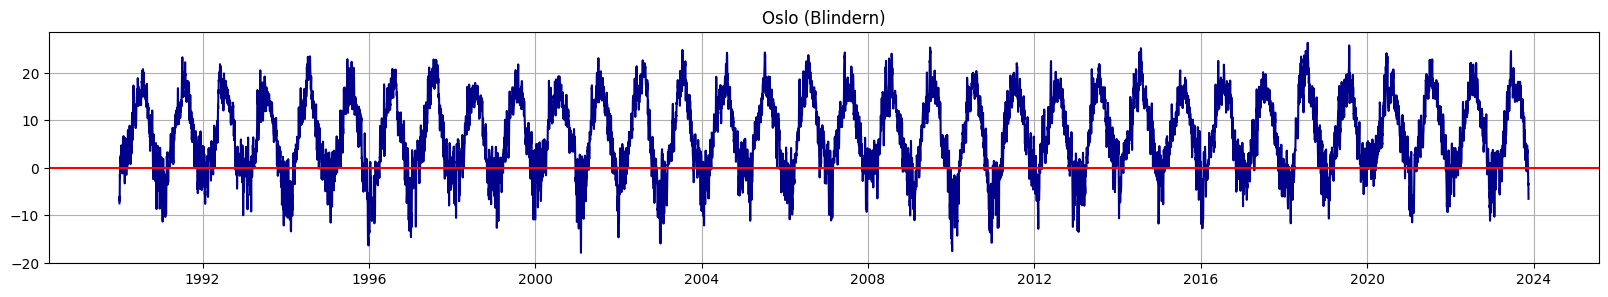

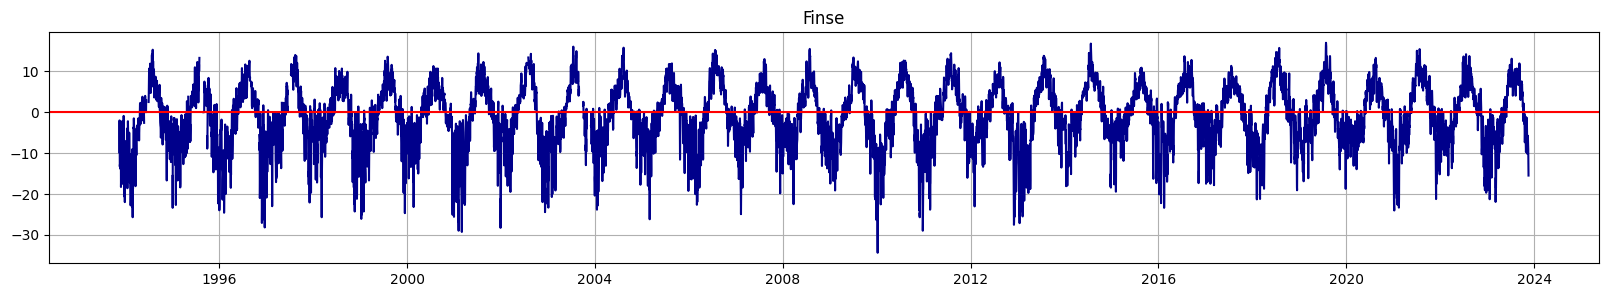

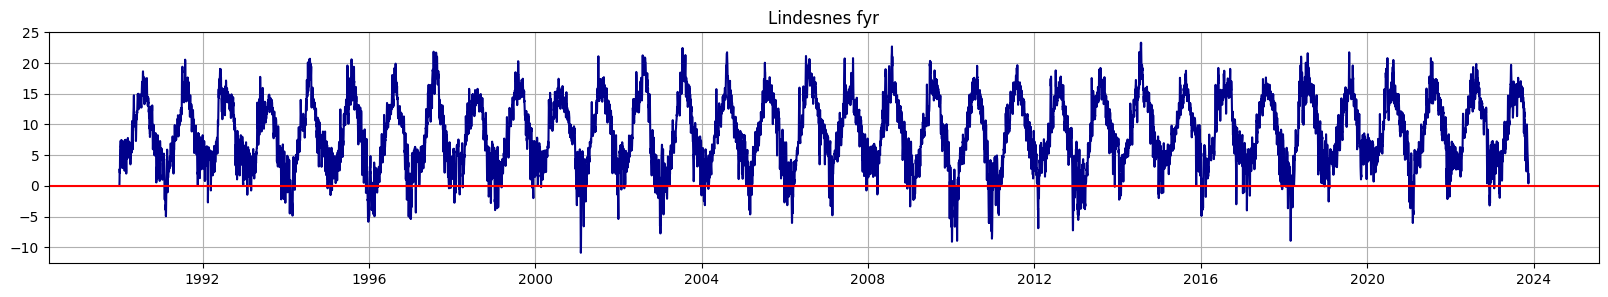

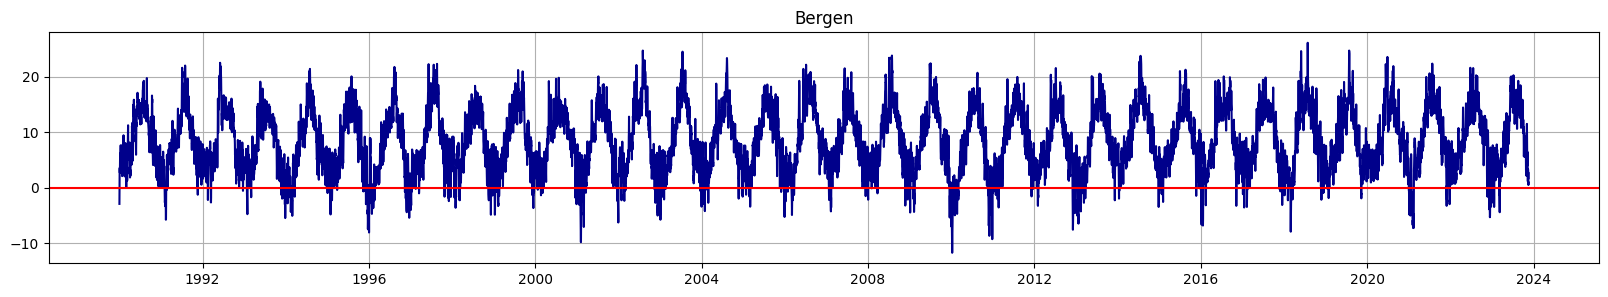

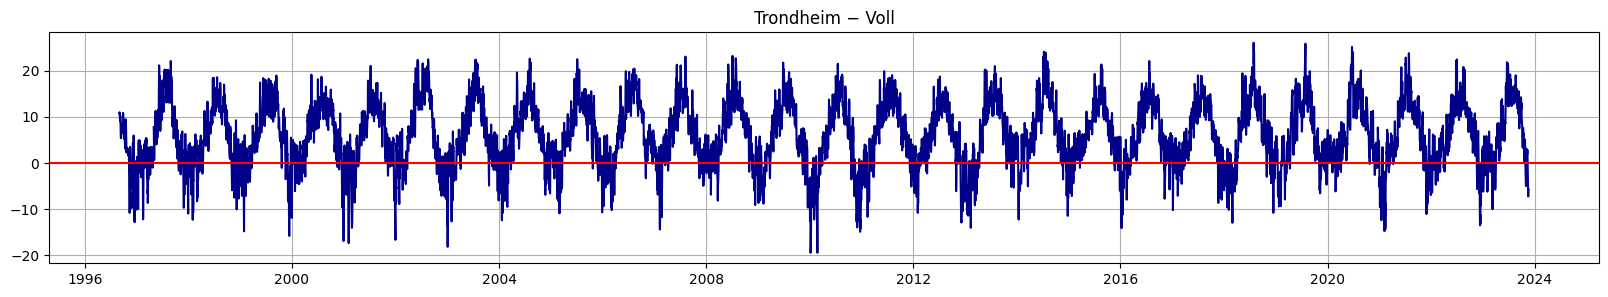

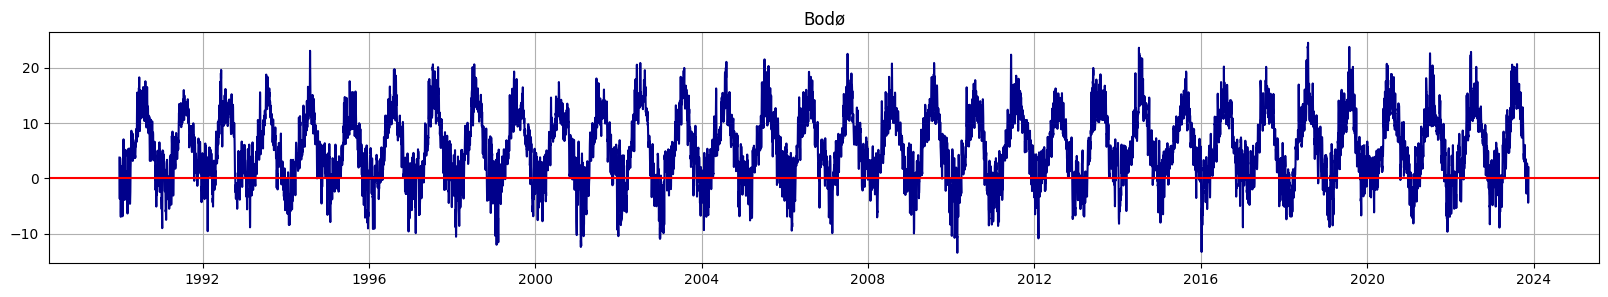

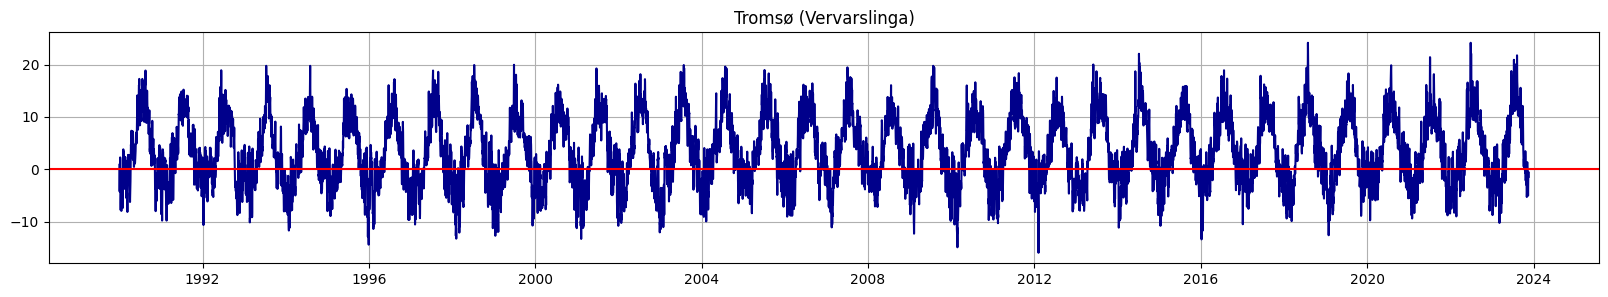

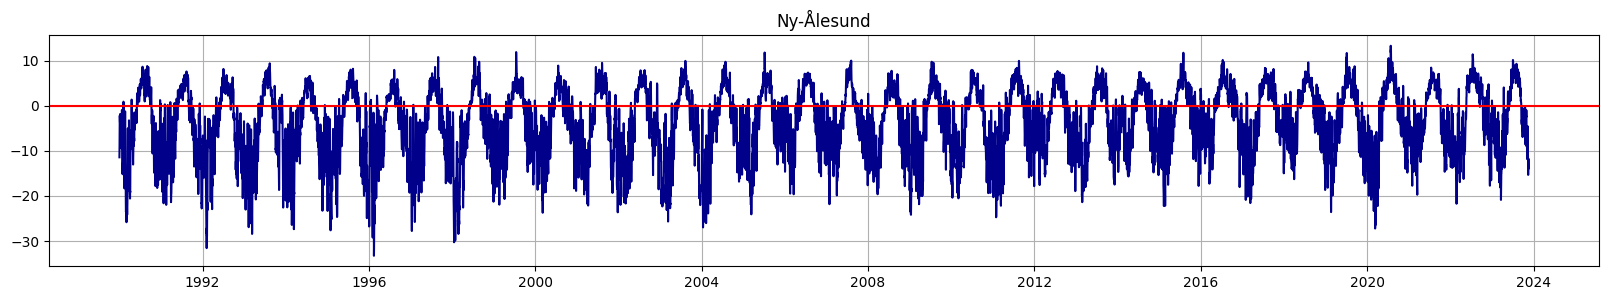

In [121]:
# Plot temperature time-series for selected stations
for col in df.columns[1:]:
    plt.figure(figsize=(20, 3))
    plt.plot(
        df['referenceTime'],
        df[:, col],
        color='darkblue',
        )
    plt.xlabel('')
    plt.grid()
    plt.title(id_names.get(col))
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()

## Forecasting using regression + ARIMA model

We want to forecast the temperature $Y_t$ assuming
$$
    Y_t = c+\beta_{\sin}\sin\left(2\pi\frac{d(t)}{365.25}\right)+\beta_{\cos}\cos\left(2\pi\frac{d(t)}{365.25}\right)+\varepsilon_t,
$$
where
$$
    (1-L)^d\Phi(L)\varepsilon_t=\Theta(L)\eta_t,\ \eta_t\sim\mathcal{N}(0, \sigma^2).
$$
That is: temperature varies, on average, like sine/cosine over the seasons around the level $c$; the deviations from the average temperature follow an ARIMA(p, d, q)-process. The function $d(t)$ maps the time index (or date) $t$ to the *day-of-year*, i.e., $d(t)\in [1, 366]$.

In [125]:
# We account for seasonality using sine and cosine as regressors
df_exog = pd.DataFrame(index=df['referenceTime'])
df_exog['sin'] = np.sin(2*pi*df_exog.index.day_of_year/365.25)
df_exog['cos'] = np.cos(2*pi*df_exog.index.day_of_year/365.25)
df_exog = pl.from_pandas(df_exog)

In [15]:
# Run an ARIMA(p,d,q) on all columns and store model ARIMA objects in a dict
models = {}
for col in df.columns:
    model = ARIMA(df[col], exog=df_exog, order=(0,0,7), trend='c')
    models[col] = model

In [16]:
# Make a dict comprehension that fits each of the ARIMA models
fits = {key: val.fit() for key, val in models.items()}

In [17]:
# Print the results for all ARIMA-models
[val.summary() for _, val in fits.items()]

[<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                SN18700   No. Observations:                12375
 Model:                 ARIMA(0, 0, 7)   Log Likelihood              -23229.919
 Date:                Sun, 19 Nov 2023   AIC                          46481.839
 Time:                        10:16:29   BIC                          46563.497
 Sample:                    01-01-1990   HQIC                         46509.189
                          - 11-18-2023                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          7.0010      0.075     92.983      0.000       6.853       7.149
 sin           -2.9837      0.106    -28.220      0.000      -3.191   

In [18]:
# Function that returns forecasts a chosen number of days ahead
def forecast(days, confidence_interval):
    # We make sine and cosine functions the chosen number of days ahead
    df_exog_forecast = pd.DataFrame(index=pd.period_range(start=df_exog.index.max()+1, periods=days, freq='d'))
    df_exog_forecast['sin'] = np.sin(2*pi*df_exog_forecast.index.day_of_year/365.25)
    df_exog_forecast['cos'] = np.cos(2*pi*df_exog_forecast.index.day_of_year/365.25)

    # We make a nested dict comprehensions that stores forecast and forecast intervals 30 days ahead
    forecasts = {key:
        {
            'forecast': val.forecast(steps=days, exog=df_exog_forecast),
            'interval': val.get_forecast(steps=days, exog=df_exog_forecast).conf_int(alpha=1-confidence_interval)
        } for key, val in fits.items()}

    return forecasts

forecasts = forecast(30, 0.9)

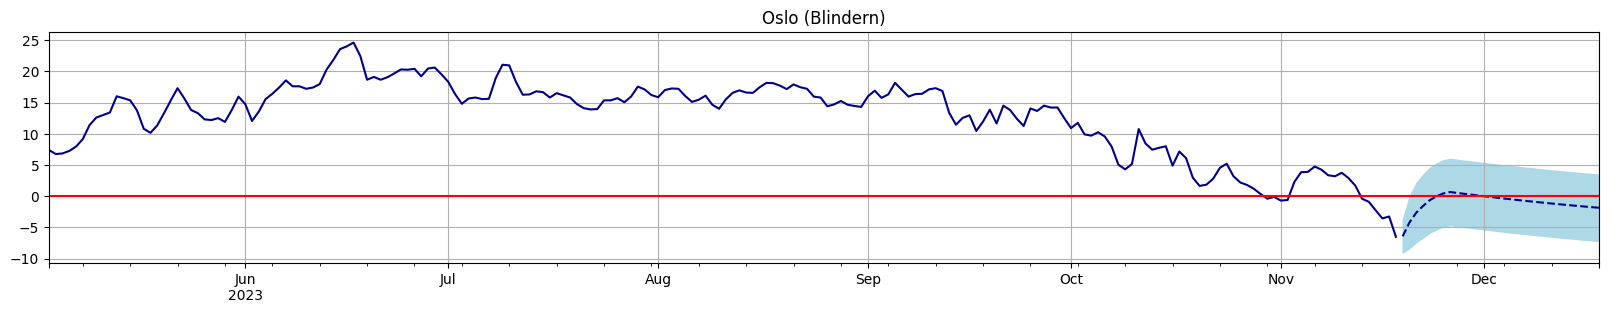

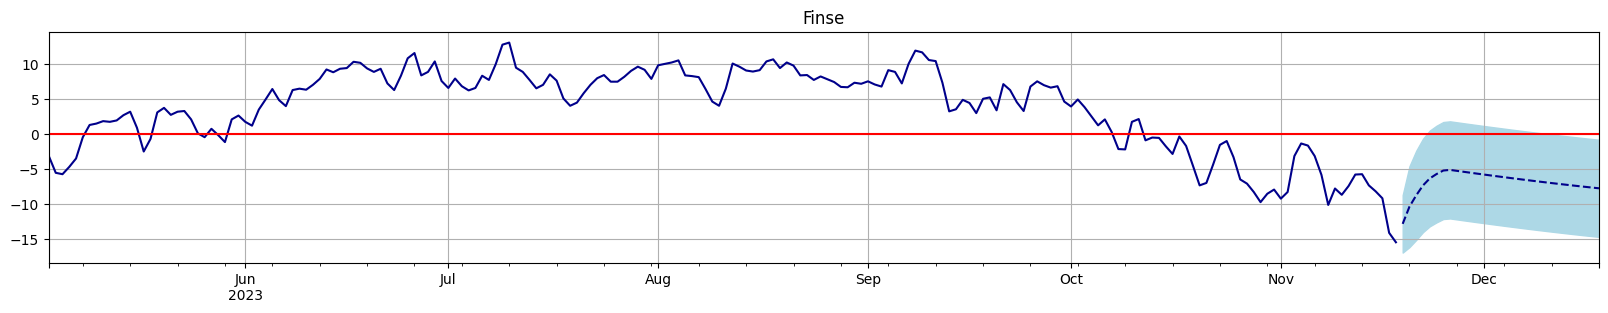

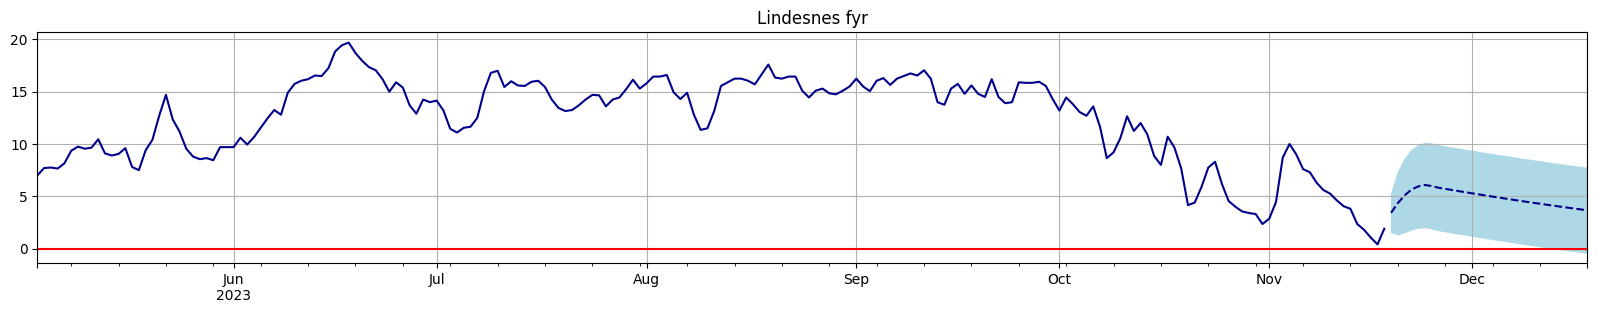

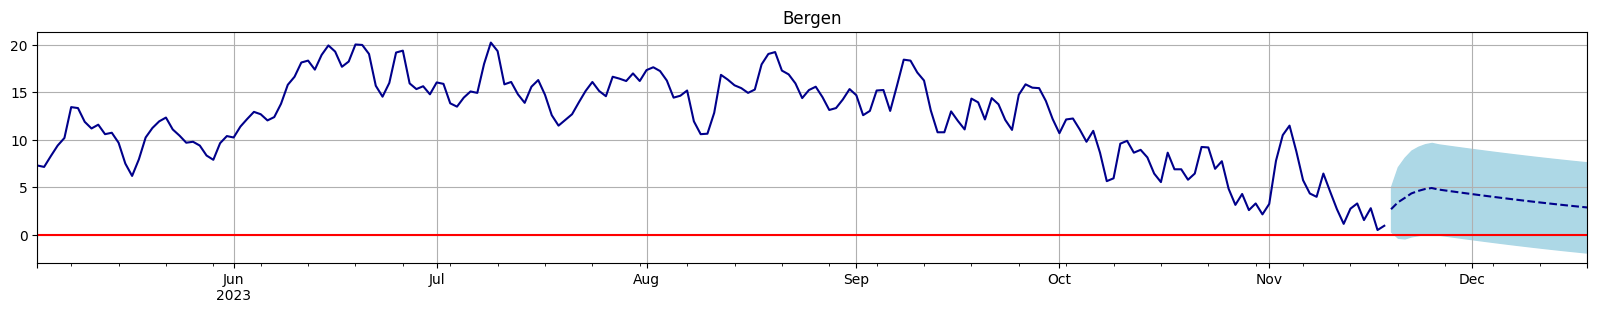

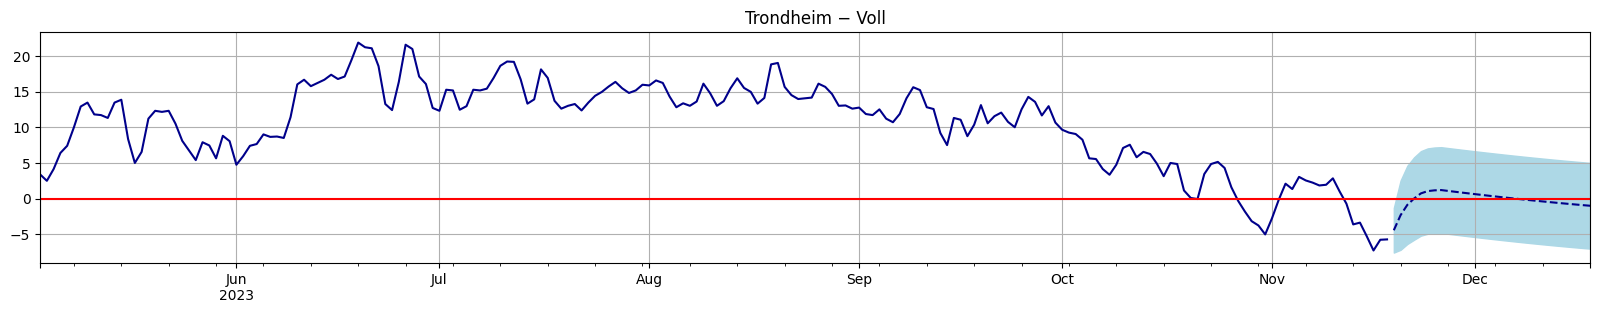

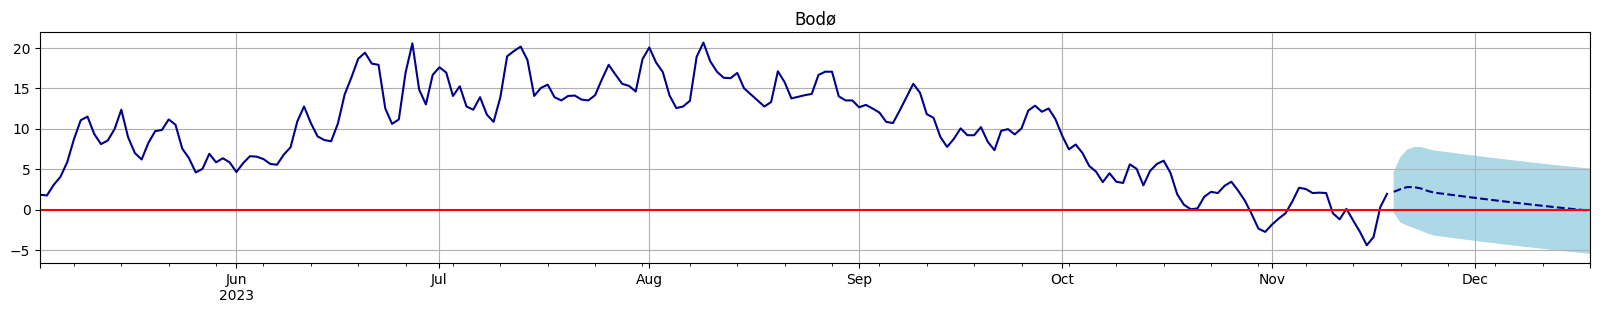

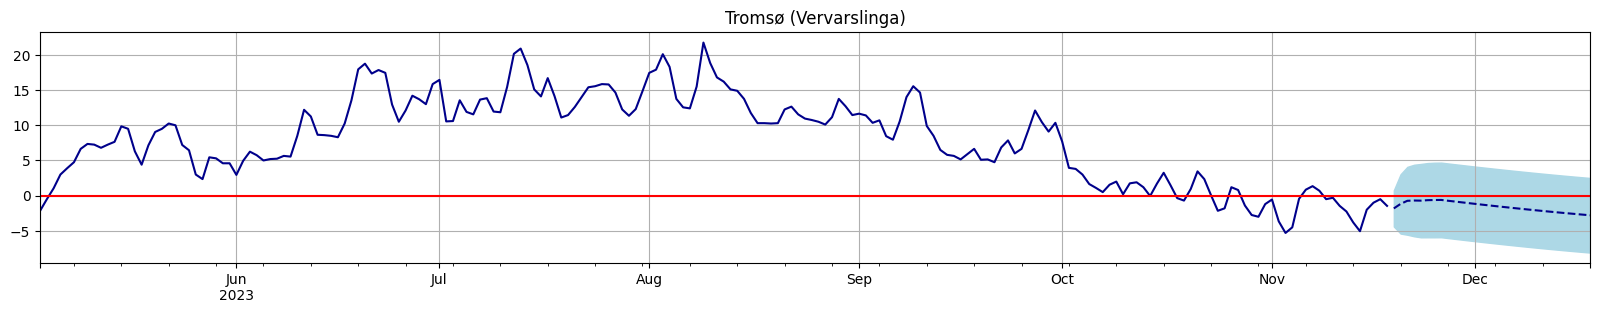

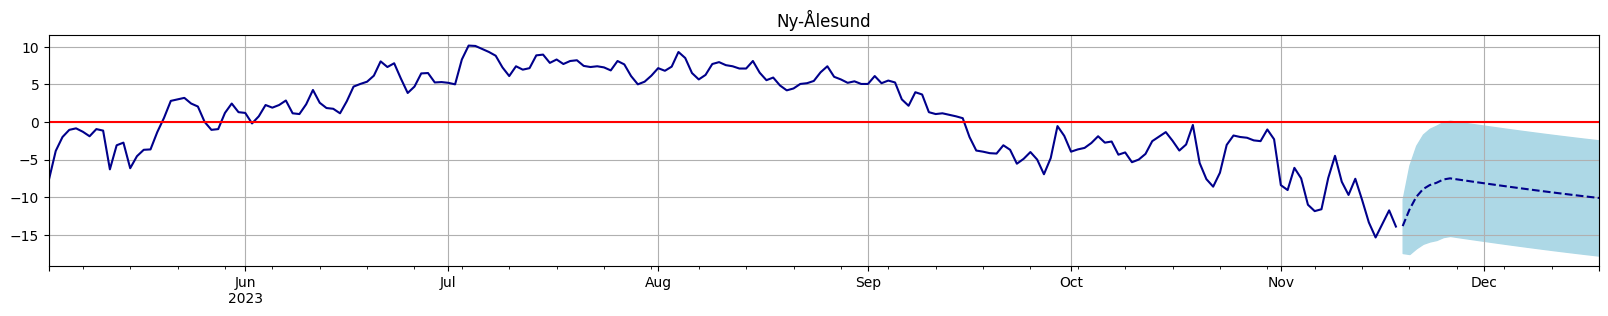

In [19]:
# Plot forecast and forecast interval
for k, (col, val) in enumerate(forecasts.items()):
    plt.figure(figsize=(20, 3))
    df.iloc[-200:, k].plot(
        color='darkblue',
        xlabel='',
        grid=True
        )
    plt.fill_between(val.get('interval').index,
                     val.get('interval').iloc[:, 0],
                     val.get('interval').iloc[:, 1],
                     color='lightblue'
                     )
    val.get('forecast').plot(
        style='--',
        color='darkblue',
        xlabel='',
        grid=True
        )
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(id_names.get(col))
    plt.show()